In [ ]:
#library and code setup
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark
import pyspark, os
from pyspark import SparkConf, SparkContext
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64/"

!pip install gdelt

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [423 kB]
Hit:12 http://ppa.launchpad.net

In [ ]:
#start spark local server
import sys, os
from operator import add
import time

os.environ["PYSPARK_PYTHON"]="python3"

import pyspark
from pyspark import SparkConf, SparkContext

#connects our python driver to a local Spark JVM running on the Google Colab server virtual machine
try:
  conf = SparkConf().setMaster("local[*]").set("spark.executor.memory", "1g")
  sc = SparkContext(conf = conf)
except ValueError:
  #it's ok if the server is already started
  pass

def dbg(x):
  """ A helper function to print debugging information on RDDs """
  if isinstance(x, pyspark.RDD):
    print([(t[0], list(t[1]) if 
            isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
  else:
    print(x)

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from datetime import date, timedelta
import pandas
import gdelt
import os

# set up gdeltpyr for version 2
gd = gdelt.gdelt(version=2)

# multiprocess the query
e = ProcessPoolExecutor()


# generic functions to pull and write data to disk based on date
def get_filename(x):
  date = x.strftime('%Y%m%d')
  return "{}_gdeltdata.csv".format(date)

def intofile(filename):
    try:
        if not os.path.exists(filename):
          date = filename.split("_")[0]
          d = gd.Search(date, table='events',coverage=False) #not updata at 15mins
          d.to_csv(filename,encoding='utf-8',index=False)
    except:
        print("Error occurred")

# pull the data from gdelt into multi files; this may take a long time
dates_before = [get_filename(x) for x in pandas.date_range('2019 Jan 1','2019 Dec 31')]
dates_after = [get_filename(x) for x in pandas.date_range('2020 Jan 1','2020 Sep 26')]
dates_after += [get_filename(x) for x in pandas.date_range('2020 Sep 28','2020 Oct 2')]
dates_after += [get_filename(x) for x in pandas.date_range('2020 Oct 5','2020 Oct 5')]
dates_after += [get_filename(x) for x in pandas.date_range('2020 Oct 9','2020 Oct 10')]
dates_after += [get_filename(x) for x in pandas.date_range('2020 Oct 18','2020 Oct 18')]
dates_after += [get_filename(x) for x in pandas.date_range('2020 Oct 25','2020 Oct 25')]
dates_after += [get_filename(x) for x in pandas.date_range('2020 Nov 10','2020 Nov 10')]
dates_after += [get_filename(x) for x in pandas.date_range('2020 Nov 18','2020 Dec 31')]
#----------------------------------------------------------------------------------------------------


results = list(e.map(intofile,dates_before+dates_after))

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

data_before = sqlContext.read.option("header", "true").csv(dates_before)
data_after = sqlContext.read.option("header", "true").csv(dates_after)

In [ ]:
# Event codes categorised into positive, neutral, and negative events.
neutral_events = ['011', '019', '020', '024', '0241', '0242', '025', '0253', 
                  '0341', '0342', '0343', '0344', '035', '040', '041', '042',
                  '043', '044', '045', '046', '080', '083', '0831', '0832', '0833',
                  '0834', '084', '0841', '0842', '090', '091', '092', '093',
                  '094', '100', '104', '1041', '1042', '1043', '1044', '105', 
                  '106', '107', '108', '110', '123', '1231', '1232', '1233', 
                  '1234', '124', '125', '126', '127', '128', '129', '140', 
                  '141', '1411', '1412', '1413', '1414', '150', '160', '166', '170']


negative_events = ['012', '016', '111', '112', '1121', '1122', '1123', '1124',
                   '1125', '113', '115', '116', '120', '121', '1211', '1212', 
                   '122', '1221', '1222', '1223', '1224', '1241', '1242',
                   '1243', '1244', '1245', '1246', '130', '131', '1311', 
                   '1312', '1313', '132', '1321', '1322', '1323', '1324', 
                   '133', '134', '135', '136', '137', '1381', '138114', 
                   '1382', '1383', '1384', '1385', '139', '142', '1421', 
                   '1422', '1423', '1424', '143', '1431', '1432', '1433', 
                   '1434', '144', '1441', '1442', '1443', '1444', '145', 
                   '1451', '1452', '1453', '1454', '161', '162', '1621', 
                   '1622', '1623', '163', '164', '165', '1661', '1662', 
                   '1663', '171', '1711', '1712', '172', '1721', '1722', 
                   '1723', '1724', '173', '174', '175', '176', '180', '181', 
                   '182', '1821', '1822', '1823', '183', '1831', '1832', 
                   '1833', '1834', '184', '185', '186', '190195', '191', 
                   '192', '193', '194', '1951', '1952', '196', '200', '201',
                   '202', '203', '204', '2041', '2042']


positive_events = ['013', '014', '015', '017', '018', '021', '0211', '0212',
                   '0213', '0214', '022', '022', '023', '0231', '0232', '0233',
                   '0234', '0243', '0244', '0251', '0252', '0254', '0255', 
                   '0256', '026', '027', '028', '030', '031', '0311', '0312',
                   '0313', '0314', '032', '032', '033', '0331', '0332', '0333', 
                   '0334', '034', '0351', '0352', '0353', '0354', '0355', '0356', 
                   '036', '037', '038', '039', '050', '051', '052', '053', 
                   '054', '055', '056', '057', '060', '061', '062', '063',
                   '064', '070', '071', '072', '073', '074', '075', '081', 
                   '0811', '0812', '0813', '0814', '082', '085', '086', '0861',
                   '0862', '0863', '087', '0871', '0872', '0873', '0874',
                   '101', '1011', '1012', '1013', '1014', '102', '103', '1031',
                   '1032', '1033', '1034', '1051', '1052', '1053', '1054', 
                   '1055', '1056', '150', '151', '152', '153', '154', '155']

def event_sign(event_code):
  return ("Positive" if event_code in positive_events else
          "Neutral" if event_code in neutral_events else
          "Negative" if event_code in negative_events else "Unknown")
  

[(('USA', 'CHN', 'Negative', 'AGR'), 0), (('USA', 'CHN', 'Negative', 'AMN'), 0), (('USA', 'CHN', 'Negative', 'BUS'), 6), (('USA', 'CHN', 'Negative', 'COP'), 0), (('USA', 'CHN', 'Negative', 'CRM'), 0), (('USA', 'CHN', 'Negative', 'CVL'), 2), (('USA', 'CHN', 'Negative', 'DEV'), 0), (('USA', 'CHN', 'Negative', 'EDU'), 8), (('USA', 'CHN', 'Negative', 'ELI'), 0), (('USA', 'CHN', 'Negative', 'ENV'), 0), (('USA', 'CHN', 'Negative', 'GOV'), 18), (('USA', 'CHN', 'Negative', 'GRP'), 0), (('USA', 'CHN', 'Negative', 'HLH'), 0), (('USA', 'CHN', 'Negative', 'HRI'), 2), (('USA', 'CHN', 'Negative', 'IGO'), 0), (('USA', 'CHN', 'Negative', 'IMG'), 0), (('USA', 'CHN', 'Negative', 'INS'), 0), (('USA', 'CHN', 'Negative', 'INT'), 0), (('USA', 'CHN', 'Negative', 'IRC'), 0), (('USA', 'CHN', 'Negative', 'JUD'), 1), (('USA', 'CHN', 'Negative', 'LAB'), 0), (('USA', 'CHN', 'Negative', 'LEG'), 1), (('USA', 'CHN', 'Negative', 'MED'), 6), (('USA', 'CHN', 'Negative', 'MIL'), 5), (('USA', 'CHN', 'Negative', 'MNC'), 14

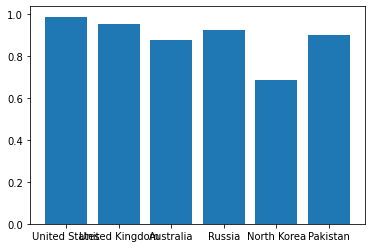

Program running time: 152.45seconds


In [ ]:
from math import sqrt
import pandas
import matplotlib.pyplot as plt
import time
T1 = time.time()
Nations_need = ['USA','GBR','AUS','RUS','PRK','PAK']
Type_codes = ['COP', 'GOV', 'INS', 'JUD', 'MIL', 'OPP', 'REB', 'SEP', 'SPY',
        'UAF', 'AGR', 'BUS', 'CRM', 'CVL', 'DEV', 'EDU', 'ELI', 'ENV',
        'HLH', 'HRI', 'LAB', 'LEG', 'MED', 'REF', 'MOD', 'RAD', 'AMN',
        'IRC', 'GRP', 'UNO', 'PKO', 'UIS', 'IGO', 'IMG', 'INT', 'MNC',
        'NGM', 'NGO', 'UIS', 'SET']
Type_codes2 = ['COP', 'GOV', 'INS', 'JUD', 'MIL', 'OPP', 'REB', 'SEP', 'SPY',
        'UAF', 'AGR', 'BUS', 'CRM', 'CVL', 'DEV', 'EDU', 'ELI', 'ENV',
        'HLH', 'HRI', 'LAB', 'LEG', 'MED', 'REF', 'MOD', 'RAD', 'AMN',
        'IRC', 'GRP', 'UNO', 'PKO', 'UIS', 'IGO', 'IMG', 'INT', 'MNC',
        'NGM', 'NGO', 'UIS', 'SET', 'Unknow Type']
def isNone(array):
    ans = []
    for i in range(len(array)):
        if array[i] != None:
            ans.append(array[i])
    ans = list(set(ans))
    if ans == []:
        ans = 'Unknow Type'
    if len(ans) == 1:
        ans = ans[0]
    return ans
def get_need_rdd(data):

    data_need = data.rdd.map(lambda row: ((row['Actor1CountryCode'], row['Actor2CountryCode'], event_sign(row['EventCode']), isNone([row['Actor1Type1Code'], row['Actor1Type2Code'], row['Actor1Type3Code'], row['Actor2Type1Code'], row['Actor2Type2Code'], row['Actor2Type3Code']])),1))
    data_need = data_need.filter(lambda x : x[0][0] in Nations_need and x[0][1] == 'CHN')
    data_need_single_type = data_need.filter(lambda x: type(x[0][3]) != list)
    data_need_multi_type = data_need.filter(lambda x: type(x[0][3]) == list)
    data_need_multi_type = data_need_multi_type.flatMap(lambda x : [((x[0][0], x[0][1], x[0][2],x[0][3][i]),1) for i in range(len(x[0][3]))])
    # dbg(data_need_multi_type)
    # dbg(data_need)
    data_need = sc.union([data_need_single_type, data_need_multi_type])
    data_merged = data_need.reduceByKey(lambda x, y : x+y).sortByKey()
    # dbg(data_merged)
    data_blank = sc.parallelize([(('USA','CHN','Negative',''),0), (('USA','CHN','Neutral',''),0), (('USA','CHN','Positive',''),0), (('USA','CHN','Unknown',''),0),(('GBR','CHN','Negative',''),0), (('GBR','CHN','Neutral',''),0), (('GBR','CHN','Positive',''),0), (('GBR','CHN','Unknown',''),0),(('AUS','CHN','Negative',''),0), (('AUS','CHN','Neutral',''),0), (('AUS','CHN','Positive',''),0), (('AUS','CHN','Unknown',''),0), (('RUS','CHN','Negative',''),0), (('RUS','CHN','Neutral',''),0), (('RUS','CHN','Positive',''),0), (('RUS','CHN','Unknown',''),0), (('PRK','CHN','Negative',''),0), (('PRK','CHN','Neutral',''),0), (('PRK','CHN','Positive',''),0), (('PRK','CHN','Unknown',''),0), (('PAK','CHN','Negative',''),0), (('PAK','CHN','Neutral',''),0), (('PAK','CHN','Positive',''),0), (('PAK','CHN','Unknown',''),0)])
    data_blank = data_blank.flatMap(lambda x : [((x[0][0], x[0][1], x[0][2], ti), 0) for ti in Type_codes2])
    data_final = sc.union([data_merged, data_blank]).reduceByKey(lambda x,y: x+y).sortByKey()

    return data_final

data_2019 = get_need_rdd(data_before)
data_2020 = get_need_rdd(data_after)
# dbg(data_2019)
# dbg(data_2020)


data_usa2019 = data_2019.filter(lambda x: x[0][0] == 'USA').sortByKey()
data_usa2020 = data_2020.filter(lambda x: x[0][0] == 'USA').sortByKey()

data_gbr2019 = data_2019.filter(lambda x: x[0][0] == 'GBR').sortByKey()
data_gbr2020 = data_2020.filter(lambda x: x[0][0] == 'GBR').sortByKey()

data_aus2019 = data_2019.filter(lambda x: x[0][0] == 'AUS').sortByKey()
data_aus2020 = data_2020.filter(lambda x: x[0][0] == 'AUS').sortByKey()

data_rus2019 = data_2019.filter(lambda x: x[0][0] == 'RUS').sortByKey()
data_rus2020 = data_2020.filter(lambda x: x[0][0] == 'RUS').sortByKey()

data_prk2019 = data_2019.filter(lambda x: x[0][0] == 'PRK').sortByKey()
data_prk2020 = data_2020.filter(lambda x: x[0][0] == 'PRK').sortByKey()

data_pak2019 = data_2019.filter(lambda x: x[0][0] == 'PAK').sortByKey()
data_pak2020 = data_2020.filter(lambda x: x[0][0] == 'PAK').sortByKey()

dbg(data_usa2019)
dbg(data_usa2020)
dbg(data_gbr2019)
dbg(data_gbr2020)
dbg(data_aus2019)
dbg(data_aus2020)
dbg(data_rus2019)
dbg(data_rus2020)
dbg(data_prk2019)
dbg(data_prk2020)
dbg(data_pak2019)
dbg(data_pak2020)

def rdd_2_vector(rdd):
    return rdd.map(lambda x: x[1]).collect()

def total_events(rdd):
    return rdd.map(lambda x: x[1]).reduce(lambda a,b: a+b)

vector_2019_usa = rdd_2_vector(data_usa2019)
vector_2020_usa = rdd_2_vector(data_usa2020)

vector_2019_gbr = rdd_2_vector(data_gbr2019)
vector_2020_gbr = rdd_2_vector(data_gbr2020)

vector_2019_aus = rdd_2_vector(data_aus2019)
vector_2020_aus = rdd_2_vector(data_aus2020)

vector_2019_rus = rdd_2_vector(data_rus2019)
vector_2020_rus = rdd_2_vector(data_rus2020)

vector_2019_prk = rdd_2_vector(data_prk2019)
vector_2020_prk = rdd_2_vector(data_prk2020)

vector_2019_pak = rdd_2_vector(data_pak2019)
vector_2020_pak = rdd_2_vector(data_pak2020)

def cosine_similarity(list_a,list_b):
    son = 0
    mother_a = 0
    mother_b = 0
    for i in range(len(list_a)):
        son+=list_a[i] * list_b[i]
        mother_a+=list_a[i]**2
        mother_b+=list_b[i]**2
    return son/(sqrt(mother_a)*sqrt(mother_b))

result_usa = cosine_similarity(vector_2019_usa,vector_2020_usa)
result_gbr = cosine_similarity(vector_2019_gbr,vector_2020_gbr)
result_aus = cosine_similarity(vector_2019_aus,vector_2020_aus)
result_rus = cosine_similarity(vector_2019_rus,vector_2020_rus)
result_prk = cosine_similarity(vector_2019_prk,vector_2020_prk)
result_pak = cosine_similarity(vector_2019_pak,vector_2020_pak)

print(result_usa)
print(result_gbr)
print(result_aus)
print(result_rus)
print(result_prk)
print(result_pak)

header1 = ['cosine similarity', '2019total','2020total']
header2 = ['United States', 'United Kingdom', 'Australia', 'Russia', 'North Korea', 'Pakistan']
table = [[result_usa, total_events(data_usa2019), total_events(data_usa2020)], [result_gbr, total_events(data_gbr2019), 
total_events(data_gbr2020)], [result_aus, total_events(data_aus2019), total_events(data_aus2020)], 
[result_rus, total_events(data_rus2019), total_events(data_rus2020)], [result_prk, total_events(data_prk2019), 
total_events(data_prk2020)], [result_pak, total_events(data_pak2019), total_events(data_pak2020)]]
print(pandas.DataFrame(table, header2, header1))
vector_list = [result_usa, result_gbr, result_aus, result_rus, result_prk, result_pak]
nation_list = ['United States', 'United Kingdom', 'Australia', 'Russia', 'North Korea', 'Pakistan']
plt.bar(range(len(vector_list)),vector_list,tick_label=nation_list)
params = {
    'figure.figsize': '13, 4'
}
plt.rcParams.update(params)
plt.show()
T2 = time.time()

print(f"Program running time: {(T2-T1):.2f}seconds")





# data_spec = data_after.rdd.map(lambda row: ((row['Actor1CountryCode'], row['Actor2CountryCode'], event_sign(row['EventCode']),row['GLOBALEVENTID'], row['SOURCEURL']),1))
# data_spec = data_spec.filter(lambda x : x[0][0] == 'PRK' and x[0][1] == 'CHN')
# dbg(data_spec.count())